## Body Crop algorithm deployment

> NOTE: If you want to run the notebook locally execute:
        
        $ docker run -it -p 8888:8888 -e OPENWHISK_AUTH=`cat ~/.wskprops | grep AUTH= | awk -F= '{print $2}'` --rm -v `pwd`:/notebooks/sf  --entrypoint jupyter-notebook ddragosd/python3aiaction  --notebook-dir=/notebooks --ip 0.0.0.0 --no-browser --allow-root
        

In [59]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from inference import SmartBodyCrop
from PIL import Image
import numpy as np

In [60]:
#model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
model_url = "models/optimized_openpose.pb"
inf = SmartBodyCrop(model_url = model_url)

## Download the deep learning (open pose) model

In [61]:
#!mkdir -p models
#!curl -L https://www.dropbox.com/s/2dw1oz9l9hi9avg/optimized_openpose.pb -o models/optimized_openpose.pb

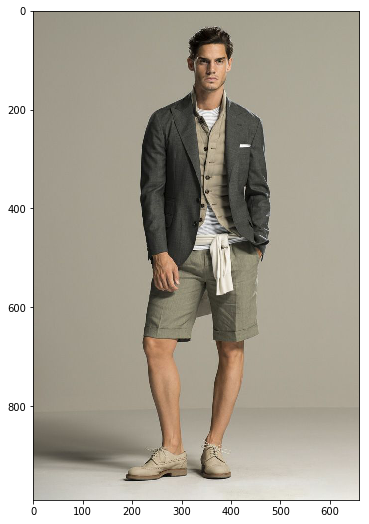

In [62]:
image = Image.open('person2.jpg')
image = np.asarray(image)
plt.figure(figsize = (18,9))
plt.imshow(image)
plt.show()

## How algorithm sees the body

image loaded in:      0.0925
tf session executed in:     13.2459
pose estimated in:      0.0100


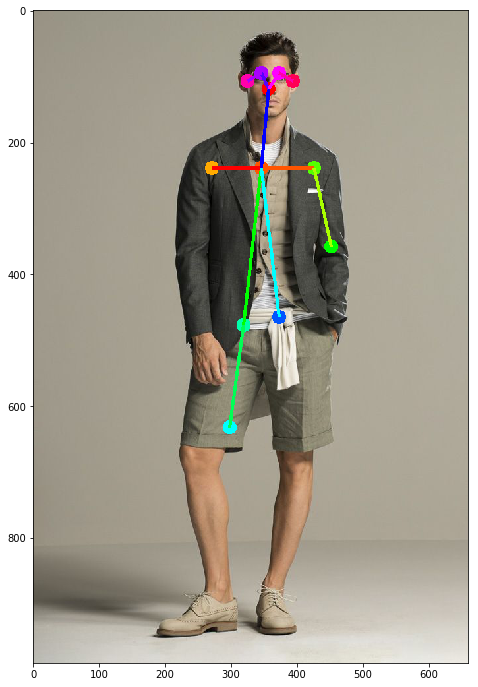

In [63]:
x = inf.detect_parts('person2.jpg')
#x = inf.detect_parts('https://cdn.shopify.com/s/files/1/1970/6605/products/Pioneer-Camp-2017-spring-new-fashion-men-shirt-long-sleeve-brand-clothing-quality-cotton-soft-shirt_e262fa2c-a279-4190-9cf7-707982189e9e.jpg?v=1501310825')
plt.figure(figsize=(24,12))
plt.imshow(x)
plt.show()

## Bodycrop based on detected body parts

image loaded in:      0.0823
tf session executed in:     14.1484
pose estimated in:      0.0082
image cropped in:      0.0292


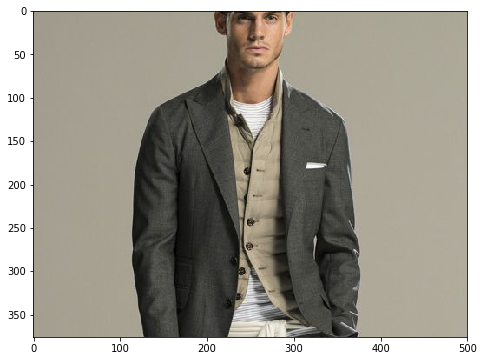

CPU times: user 45.8 s, sys: 3.1 s, total: 48.9 s
Wall time: 14.5 s


In [64]:
%%time
x, coordinates = inf.infer('person2.jpg','Eyes','Hips')
plt.figure(figsize = (10,6))
plt.imshow(x)
plt.show()

### Draw the crop coordinates on the original image

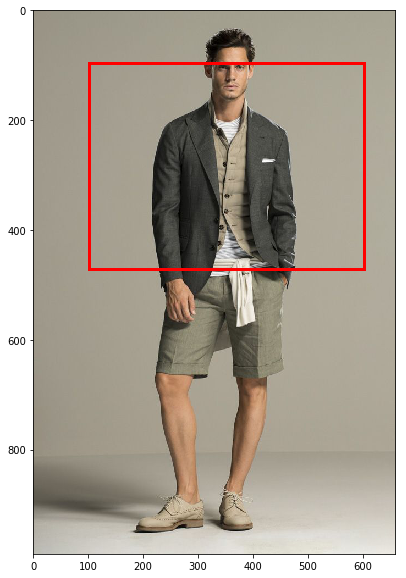

In [65]:
img = Image.open('person2.jpg')

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(14,10))
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle(
    (coordinates.get('x'),coordinates.get('y')),
    coordinates.get('width'),coordinates.get('height'),
    linewidth = 3, 
    edgecolor = 'r',
    facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

## Test with another image too

image loaded in:      0.0755
tf session executed in:      6.1042
pose estimated in:      0.0054
image cropped in:      0.0144
{'y': 36, 'width': 224, 'height': 168, 'x': 58}


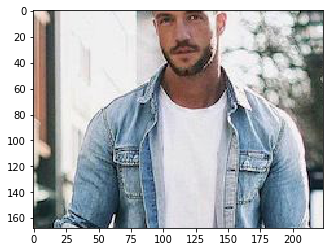

In [66]:
x, coordinates = inf.infer('fashion-men-1.jpg','Eyes','Elbows')
print(coordinates)
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

## Test with a remote image 

image downloaded in :     0.3835
image loaded in:      0.3965
tf session executed in:      4.2261
pose estimated in:      0.0055
image cropped in:      0.0051


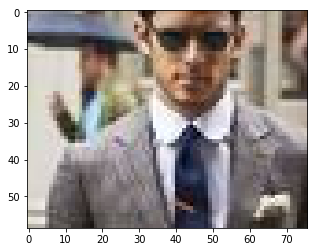

In [67]:
x, coordinates = inf.infer('https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg','Eyes','Elbows')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

# Deploy the algorithm as a function

### 1. Write the function

The function expects the following parameters as input:
* `model_url` - the location of the model
* `image` - the image location. It can be an object, or a string. I.e. 
  ```
  {
      uri: "https://...",
      headers: {
          "Authorization": "Bearer ...",
      }
  }
  ```
* `from_upper` - the upper part of the body to start the crop from. I.e. _Eyes_, _Nose_, _Neck_
* `to_lower` - the lower part of the body to stop the crop at. I.e. _Hip_, _Knees_, _Ankles_

The function should return information needed to crop the body. I.e. 
```
{
  X: 100,
  Y: 100,
  W: 200,
  H: 100
}
```

In [68]:
%%writefile smart_body_crop.py

from inference import SmartBodyCrop

def action_handler(args):
    print(args)
    model_url = args.get('model_url')
    body_crop = SmartBodyCrop(model_url = model_url)
    print("SmartBodyCrop.initialized=", SmartBodyCrop.initialized)
    crop_img, crop_coordinates = body_crop.infer(
                    args.get('image'), 
                    args.get('from_upper'), 
                    args.get('to_lower'))
    return {
        'X': crop_coordinates.get('x'),
        'Y': crop_coordinates.get('y'),
        'W': crop_coordinates.get('width'),
        'H': crop_coordinates.get('height')
    }
    

Overwriting smart_body_crop.py


### Test the function locally

In [69]:
%%time
from smart_body_crop import action_handler
action_response = action_handler({ 
    'model_url': model_url,
    'image': "https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg",
    'from_upper': 'Eyes',
    'to_lower': 'Elbows'})

print(action_response)

{'from_upper': 'Eyes', 'image': 'https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg', 'to_lower': 'Elbows', 'model_url': 'models/optimized_openpose.pb'}
SmartBodyCrop.initialized= True
image downloaded in :     0.0511
image loaded in:      0.0614
tf session executed in:      3.2254
pose estimated in:      0.0057
image cropped in:      0.0059
{'W': 76, 'H': 59, 'Y': 58, 'X': 67}
CPU times: user 5.92 s, sys: 1.3 s, total: 7.22 s
Wall time: 3.33 s


### 2. Configure Apache OpenWhisk as the FaaS Provider to deploy the function

In [70]:
%%bash
which wsk && exit
echo "Installing wsk CLI ..."
curl -L https://github.com/apache/incubator-openwhisk-cli/releases/download/latest/OpenWhisk_CLI-latest-linux-amd64.tgz -o /tmp/wsk.tgz 
tar xvfz /tmp/wsk.tgz -C /tmp/
mv /tmp/wsk /usr/local/bin

/usr/local/bin/wsk


#### Configure Apache OpenWhisk credentials


In [71]:
from pathlib import Path
import os
home = str(Path.home())
file = open(home + "/.wskprops","w") 
file.write('AUTH=' + os.environ.get('OPENWHISK_AUTH') + "\n")
file.write('APIHOST=runtime.adobe.io')
file.close()

### 3. Deploy the function

The function must ZIP the other dependent python scripts used to train the model. The action code must be places in a file called `__main__.py`.

In [14]:
%%bash
mkdir -p action_package

cp smart_body_crop.py action_package/__main__.py
cp *.py action_package/
cd action_package && zip -9 -r ../action.zip ./

updating: smart_body_crop.py (deflated 60%)
updating: common.py (deflated 68%)
updating: inference.py (deflated 74%)
updating: __main__.py (deflated 60%)


In [43]:
model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"

In [44]:
%%bash -s "$model_url"

wsk action update smart_body_crop action.zip --main action_handler  \
    --param model_url "$1" \
    --param from_upper Eyes \
    --param to_lower Hips \
    --memory 3891 \
    --docker ddragosd/openwhisk-python3aiaction

ok: updated action smart_body_crop


In [45]:
!wsk action get smart_body_crop

ok: got action smart_body_crop
{
    "namespace": "ddascal",
    "name": "smart_body_crop",
    "version": "0.0.10",
    "exec": {
        "kind": "blackbox",
        "image": "ddragosd/openwhisk-python3aiaction",
        "main": "action_handler",
        "binary": true
    },
    "annotations": [
        {
            "key": "exec",
            "value": "blackbox"
        }
    ],
    "parameters": [
        {
            "key": "model_url",
            "value": "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
        },
        {
            "key": "from_upper",
            "value": "Eyes"
        },
        {
            "key": "to_lower",
            "value": "Hips"
        }
    ],
    "limits": {
        "timeout": 60000,
        "memory": 3891,
        "logs": 10
    },
    "publish": false
}


In [46]:
!wsk action invoke smart_body_crop --param image "https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg" \
  --param from_upper Eyes --param to_lower Elbows

ok: invoked /_/smart_body_crop with id 476bda1a6dae4761abda1a6dae8761fd


### Note on first run 
On initial run the function has to:
* (potentially) pull the docker image
* download the model

These steps will take a few seconds.

In [50]:
!wsk activation get 476bda1a6dae4761abda1a6dae8761fd

ok: got activation 476bda1a6dae4761abda1a6dae8761fd
{
    "namespace": "ddascal",
    "name": "smart_body_crop",
    "version": "0.0.10",
    "subject": "ddascal",
    "activationId": "476bda1a6dae4761abda1a6dae8761fd",
    "start": 1541375792692,
    "end": 1541375840902,
    "duration": 48210,
    "response": {
        "status": "success",
        "statusCode": 0,
        "success": true,
        "result": {
            "H": 59,
            "W": 76,
            "X": 67,
            "Y": 58
        }
    },
    "logs": [
        "2018-11-04T23:56:34.002302816Z stdout: {'image': 'https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg', 'to_lower': 'Elbows', 'from_upper': 'Eyes', 'model_url': 'https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb'}",
        "2018-11-04T23:56:34.002376041Z stdout: SmartBodyCrop.initialized= False",
        "2018-11-04T23:56:34.066506946Z stdout: image downloaded in :     0.0641"

### Invoke the action again

This time it should respond much faster as it has been pre-warmed.

In [72]:
%%time
!wsk action invoke smart_body_crop --param image "https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg" \
  --param from_upper Eyes --param to_lower Elbows -b

ok: invoked /_/smart_body_crop with id c1c9c34b3c414b9589c34b3c41fb9510
{
    "activationId": "c1c9c34b3c414b9589c34b3c41fb9510",
    "annotations": [
        {
            "key": "limits",
            "value": {
                "logs": 10,
                "memory": 3891,
                "timeout": 60000
            }
        },
        {
            "key": "path",
            "value": "ddascal/smart_body_crop"
        },
        {
            "key": "kind",
            "value": "blackbox"
        },
        {
            "key": "waitTime",
            "value": 81
        }
    ],
    "duration": 1657,
    "end": 1541376296757,
    "logs": [],
    "name": "smart_body_crop",
    "namespace": "ddascal",
    "publish": false,
    "response": {
        "result": {
            "H": 59,
            "W": 76,
            "X": 67,
            "Y": 58
        },
        "status": "success",
        "success": true
    },
    "start": 1541376295100,
    "subject": "ddascal",
    "version": "0.0.1